In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Load the dataset

In [2]:
df = pd.read_csv('data/all_data.csv')

The dataset has 1,167,937 articles.

## EDA

In [3]:
df.shape

(1167937, 4)

We have 4 columns:
1. source - This is the news source which published the article
2. title - The title of the article
3. content - The actual article
4. bias - This is the label that we are trying to predict:
    * -2 = Extreme Left
    * -1 = Center Left
    * 0 = Center
    * 1 = Center Right
    * 2 = Extreme Right


In [4]:
df.head()

,source,title,content,bias
0,hotair,Trump: If the Senate won't convene and vote on...,He understands that he ’ s going nuclear on Mc...,2
1,hotair,Will schools reopen in the fall and if so what...,"Major cities like Los Angeles and New York , p...",2
2,hotair,Birx: How did China and the WHO not realize im...,Her point is simple .\nGiven how quickly we ’ ...,2
3,hotair,Even more on the NY Times' hypocrisy over Bide...,I continue to be somewhat stunned by the NY Ti...,2
4,hotair,NIMBY alert: Don't put the infected homeless i...,We ’ ve been keeping an eye on how the pandemi...,2


### Remove missing values

Check for any null values

In [8]:
df.isna().sum()

source         0
title         32
content    12896
bias           0
dtype: int64

There are 12,896 articles with missing values. We will remove all rows with missing values as we cannot use them and we have large amounts of data

In [10]:
df.dropna(axis = 0, inplace = True)

We have removed all the missing values

In [11]:
df.isna().sum()

source     0
title      0
content    0
bias       0
dtype: int64

### Distributions

Let's look at the distribution of the bias.

Most of the articles are extreme right, 41.7% while only 4.8% of the data comes from center 

In [7]:
df['bias'].value_counts(normalize=True)* 100

 2    41.700280
-1    29.332661
 1    13.091288
-2    11.065494
 0     4.810277
Name: bias, dtype: float64

Let's look at this graphically

/Users/daronbiddle/Desktop/ITC/Data_Science/env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


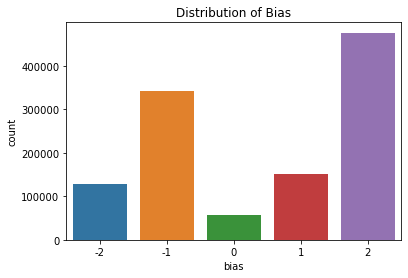

In [13]:
sns.countplot(df['bias'])
plt.title('Distribution of Bias');

Let's look at the distribution of the sources

We have 221 unique news sources, plotting these will not look good.

In [20]:
df['source'].nunique()

221

We can see that there are a lot of sources which only have a few articles, we can group these into an 'other' category for plotting

In [42]:
df['source'].value_counts()

thesun                62317
theindependent        56797
eveningstandard       45299
sputnik               39491
whatreallyhappened    35745
                      ...  
endthefed                 1
forbes                    1
hangthebankers            1
vanityfair                1
thejakartapost            1
Name: source, Length: 221, dtype: int64

As a percentage of all the articles

In [43]:
df['source'].value_counts(normalize=True)* 100

thesun                5.395365
theindependent        4.917447
eveningstandard       3.921957
sputnik               3.419105
whatreallyhappened    3.094778
                        ...   
endthefed             0.000087
forbes                0.000087
hangthebankers        0.000087
vanityfair            0.000087
thejakartapost        0.000087
Name: source, Length: 221, dtype: float64

Plot the distribution of the sources which have at least 5,000 articles

We can see that there are certain sources which publish a majority of the articles

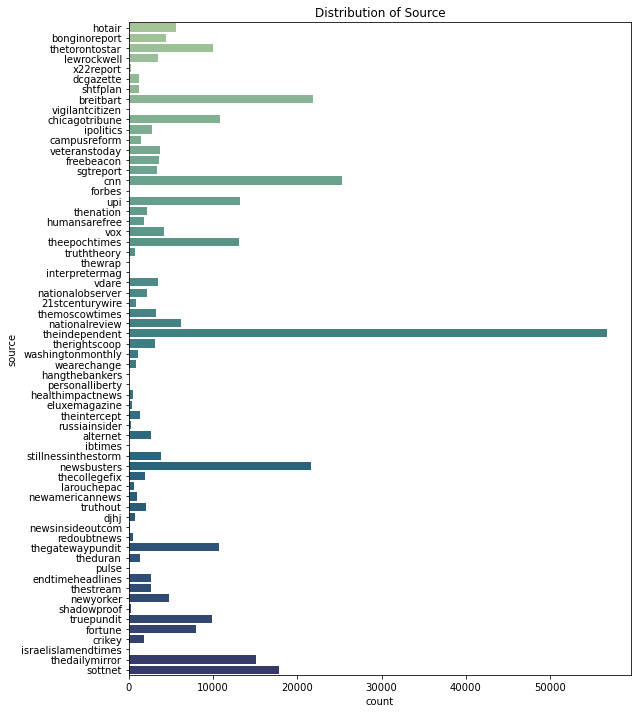

In [67]:
plt.figure(figsize = (9,12))
sns.countplot(y =  df[df['source'].isin(df['source'].unique()[(df['source'].value_counts()> 5000)].tolist())]['source'], palette='crest')
plt.title('Distribution of Source');

Let's look at the distribution of the lengths of the articles

We can see that the distribution is very right skewed and we have some very large outliers which are distorting the distribution.

We will remove these large outliers, as well as removing very short articles

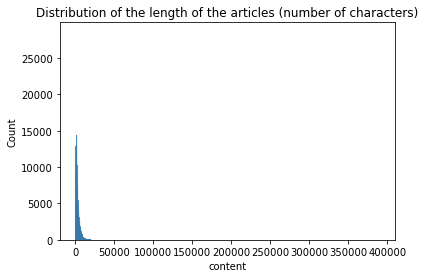

In [70]:
sns.histplot(df['content'].apply(len))
plt.title('Distribution of the length of the articles (number of characters)');

In [71]:
df = df[(df['content'].apply(len) > 1000) & (df['content'].apply(len) < 20000)]

This distribution looks a bit better

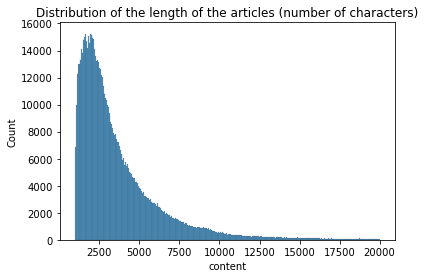

In [72]:
sns.histplot(df['content'].apply(len))
plt.title('Distribution of the length of the articles (number of characters)');

This now looks like a more reasonable distribution of the number of words in an article

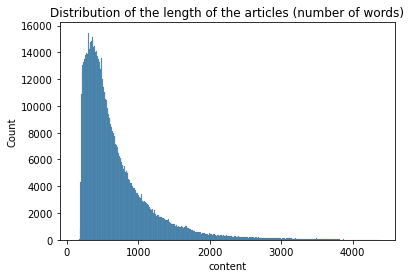

In [74]:
sns.histplot(df['content'].apply(lambda text: len(text.split(' '))))
plt.title('Distribution of the length of the articles (number of words)');

It seems like all of the biasses have the same distribution of article length

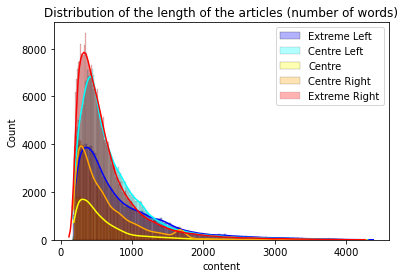

In [82]:
colors = ['blue', 'cyan', 'yellow', 'orange', 'red']
biasses = [-2,-1,0,1,2]
labels = ['Extreme Left','Centre Left', 'Centre', 'Centre Right', 'Extreme Right']

for b,l, c in zip(biasses, labels , colors):
    sns.histplot(df[df['bias'] == b]['content'].apply(lambda text: len(text.split(' '))), alpha = 0.3, color = c, label = l, kde=True)
    plt.legend()
    
plt.title('Distribution of the length of the articles (number of words)');

### Subsetting the data

In order to make it easier for the model to learn, we thought it would be best to only consider the following biasses:
* Extreme Left
* Centre
* Extreme Right

we will now only look the the subset of the data falling into these categories

In [90]:
df = df[df['bias'].isin([-2,0,2])]

We now only have 519,453 articles

In [91]:
df.shape

(519453, 4)

And 150 sources

In [92]:
df['source'].nunique()

150

As we can see, the data is very inbalanced. We have a large majority of the data that is extreme right.

We will undersample to the level of the center group as this will improve the model and reduce the amount of data.

/Users/daronbiddle/Desktop/ITC/Data_Science/env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


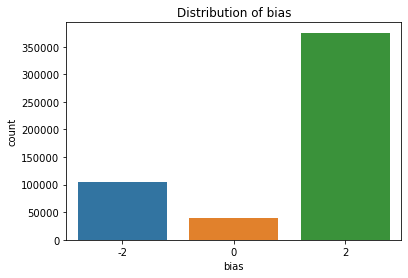

In [94]:
sns.countplot(df['bias'])
plt.title('Distribution of bias');

In [95]:
g = df.groupby('bias')
df = g.apply(lambda x: x.sample(g.size().min())).droplevel('bias').reset_index(drop=True)

In [97]:
df.shape

(119604, 4)

We have now got a balanced dataset, and a much smaller data set this will help us as we are dealing with large textual data

/Users/daronbiddle/Desktop/ITC/Data_Science/env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


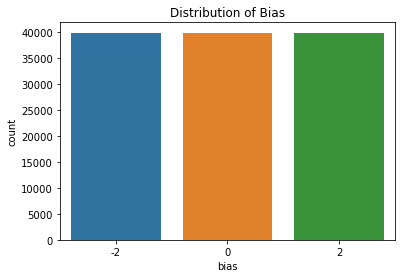

In [98]:
sns.countplot(df['bias'])
plt.title('Distribution of Bias');

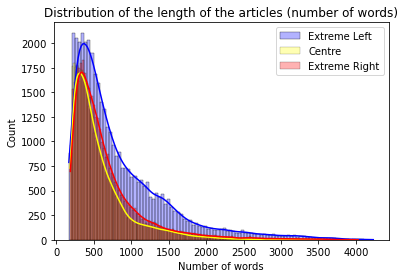

In [100]:
colors = ['blue', 'yellow', 'red']
biasses = [-2,0,2]
labels = ['Extreme Left','Centre', 'Extreme Right']

for b,l, c in zip(biasses, labels , colors):
    sns.histplot(df[df['bias'] == b]['content'].apply(lambda text: len(text.split(' '))), alpha = 0.3, color = c, label = l, kde=True)
    plt.xlabel('Number of words')
    plt.legend()
    
plt.title('Distribution of the length of the articles (number of words)');